In [1]:
from Architectures.VAE import VAE
from Data.load import load
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

In [31]:
groups = {}
for group in tqdm(["CN","MCI","AD"],"Opening faster"):
    groups[group]=np.load(open(f"Data/D3-{group}.npy","br"))

Opening faster: 100%|██████████| 3/3 [00:19<00:00,  6.46s/it]


In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, Model
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the sampling function for the reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * logvar) * epsilon

# Define the VAE model
class VAE(keras.Model):
    def __init__(
            self,
            input_shape,
            halvings=4,
            init_hidden_depth=8,
            latent_dim=1_000,
            output_activation="tanh",
            lambda_=1e-5,
            hidden_activation=activations.leaky_relu
            ):
        super(VAE, self).__init__()
        self.lambda_ = lambda_

        #if len(input_shape) == 4: 
        #    input_shape = (list(input_shape) + [1])[-4:] # (8, 80, 96, 80) -> [8, 80, 96, 80, 1] -> [80, 96, 80, 1] 
        #if len(input_shape) == 3:
        #    input_shape = (list(input_shape) + [1])[-3:] # (8, 80, 96) -> [8, 80, 96, 1] -> [80, 96, 1] 
        #print(f"Interpreted image shape: {tuple(input_shape)}", end=" ")

        
        shape_changed=False
        if input_shape[-1]>3:
            input_shape = list(input_shape) + [1]
            shape_changed=True
        if len(input_shape)>4:
            input_shape = input_shape[-4:]
            shape_changed=True
        if shape_changed: print(f"Interpreted image shape: {tuple(input_shape)}")


        # Encoder
        encoder_input = x = layers.Input(shape=input_shape)
        depth = init_hidden_depth
        for _ in range(halvings):
            x = layers.Conv3D(depth, (3, 3, 3), strides=2, activation=hidden_activation, padding="same")(x)
            x = layers.Dropout(0.05)(x)
            depth <<= 1

        pre_flatten_shape = x.shape
        print(f"Pre-flattened latent shape: {pre_flatten_shape}")
        x = layers.Flatten()(x)
        
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        
        self.encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=(latent_dim,))
        x = layers.Dense(pre_flatten_shape[1] * pre_flatten_shape[2] * pre_flatten_shape[3] * pre_flatten_shape[4], activation="relu")(decoder_input)
        x = layers.Reshape(pre_flatten_shape[1:])(x)
        
        for _ in range(halvings):
            depth >>= 1
            x = layers.Conv3D(depth, (3, 3, 3), activation=hidden_activation, padding="same")(x)
            x = layers.UpSampling3D((2, 2, 2))(x)
        decoded = layers.Conv3D(1, (3, 3, 3), activation=output_activation, padding="same")(x)
        self.decoder = Model(decoder_input, decoded, name="decoder")
    
    def call(self, inputs):
        z, mu, logvar = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))*self.lambda_
        self.add_loss(kl_loss)
        return reconstructed
    
    def save(self, path):
        """Save the VAE model, encoder, and decoder to disk."""
        os.makedirs(path, exist_ok=True)
        self.encoder.save(os.path.join(path, "encoder.keras"))
        self.decoder.save(os.path.join(path, "decoder.keras"))
        print(f"Models saved to {path}")
    
    @staticmethod
    def open(path):
        """Load the VAE model, encoder, and decoder from disk."""
        encoder = tf.keras.models.load_model(os.path.join(path, "encoder.keras"), custom_objects={'Sampling': Sampling})
        decoder = tf.keras.models.load_model(os.path.join(path, "decoder.keras"))
        
        # Create an instance of VAE without initializing models
        vae = VAE.__new__(VAE)
        vae.encoder = encoder
        vae.decoder = decoder
        
        print("Models loaded successfully.")
        return vae


In [33]:

# Instantiate the VAE model
latent_dim = 35
vae = VAE(groups["CN"].shape,latent_dim=latent_dim,halvings=3, init_hidden_depth=20, lambda_=1e-5)
vae.compile(optimizer=keras.optimizers.Adam(), loss="mse")

Interpreted image shape: (80, 96, 80, 1)
Pre-flattened latent shape: (None, 10, 12, 10, 80)


In [42]:
train = groups["CN"][0:10]
vae.fit(train, train, epochs=20, batch_size=32, verbose=True)

#vae.save("C:/Users/kiran/Documents/_UIS/sem6/BACH/DementiaMRI/AE_ADJ_models/jon/ok")

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0072
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0075
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0070
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0076
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0068
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0071
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0062
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0067
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0063
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0067
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0061
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0062
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0061
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0062
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0059
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0062
E

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


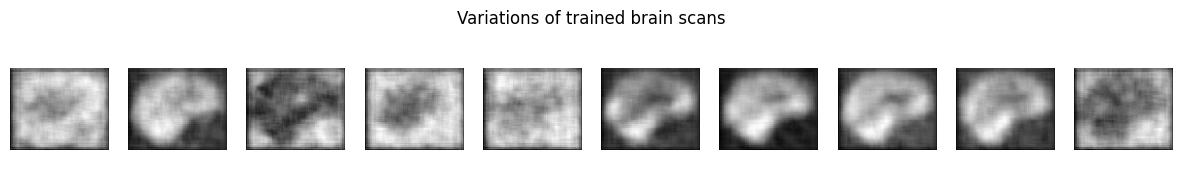

In [41]:
num_samples = 10
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
generated_images = vae.decoder.predict(random_latent_vectors)

plt.figure(figsize=(15, 2))
plt.title("Variations of trained brain scans")
plt.axis("off")
for i in range(num_samples):
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(np.rot90(generated_images[i,40,:,:]), cmap="gray")
    ax.axis("off")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import History
import numpy as np
import matplotlib.pyplot as plt
import os
import json

class VAE:
    def __init__(self, input_dim, hidden_dim, latent_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Build the encoder, decoder, and full VAE
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()
        self.vae = self._build_vae()
        
        # Initialize history dictionary
        self.history = {'loss': [], 'reconstruction_loss': [], 'kl_loss': [], 'val_loss': []}
        
    def _build_encoder(self):
        """Build the encoder model."""
        encoder_inputs = keras.Input(shape=(self.input_dim,))
        x = layers.Dense(self.hidden_dim, activation='relu')(encoder_inputs)
        
        # Mean and log variance for latent space
        z_mean = layers.Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = layers.Dense(self.latent_dim, name='z_log_var')(x)
        
        # Sampling layer using reparameterization trick
        z = Sampling()([z_mean, z_log_var])
        
        # Create encoder model
        encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
        return encoder
    
    def _build_decoder(self):
        """Build the decoder model."""
        latent_inputs = keras.Input(shape=(self.latent_dim,))
        x = layers.Dense(self.hidden_dim, activation='relu')(latent_inputs)
        decoder_outputs = layers.Dense(self.input_dim, activation='sigmoid')(x)
        
        # Create decoder model
        decoder = Model(latent_inputs, decoder_outputs, name='decoder')
        return decoder
    
    def _build_vae(self):
        """Combine encoder and decoder into VAE model."""
        inputs = keras.Input(shape=(self.input_dim,))
        z_mean, z_log_var, z = self.encoder(inputs)
        outputs = self.decoder(z)
        
        # Create the VAE model
        vae = Model(inputs, outputs, name='vae')
        
        # Add KL divergence loss
        reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs) * self.input_dim
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        
        vae.add_loss(vae_loss)
        vae.add_metric(reconstruction_loss, name='reconstruction_loss')
        vae.add_metric(kl_loss, name='kl_loss')
        
        return vae
    
    def compile(self, optimizer='adam'):
        """Compile the VAE model."""
        self.vae.compile(optimizer=optimizer)
    
    def fit(self, x_train, epochs=10, batch_size=128, validation_data=None, verbose=1):
        """Train the VAE model."""
        # Custom callback to capture metrics
        class MetricsCallback(keras.callbacks.Callback):
            def __init__(self, history_dict):
                self.history_dict = history_dict
                
            def on_epoch_end(self, epoch, logs=None):
                for key, value in logs.items():
                    if key not in self.history_dict:
                        self.history_dict[key] = []
                    self.history_dict[key].append(float(value))
        
        # Train the model
        history_callback = MetricsCallback(self.history)
        callbacks = [history_callback]
        
        self.vae.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(validation_data, validation_data) if validation_data is not None else None,
            callbacks=callbacks,
            verbose=verbose
        )
        
        return self.history
    
    def encode(self, x):
        """Encode data to latent space."""
        z_mean, z_log_var, z = self.encoder.predict(x)
        return z_mean
    
    def decode(self, z):
        """Decode from latent space."""
        return self.decoder.predict(z)
    
    def reconstruct(self, x):
        """Reconstruct input data."""
        return self.vae.predict(x)

    def generate(self, n_samples=1):
        """Generate samples from random points in latent space."""
        z_sample = np.random.normal(size=(n_samples, self.latent_dim))
        return self.decode(z_sample)
    
    def save_models(self, directory="vae_models"):
        """Save encoder, decoder, full VAE model and training history."""
        # Create directory if it doesn't exist
        os.makedirs(directory, exist_ok=True)
        
        # Save models
        self.encoder.save(os.path.join(directory, "encoder.h5"))
        self.decoder.save(os.path.join(directory, "decoder.h5"))
        self.vae.save(os.path.join(directory, "vae.h5"))
        
        # Save model configuration
        config = {
            'input_dim': self.input_dim,
            'hidden_dim': self.hidden_dim,
            'latent_dim': self.latent_dim
        }
        
        with open(os.path.join(directory, "config.json"), 'w') as f:
            json.dump(config, f)
        
        # Save training history
        with open(os.path.join(directory, "history.json"), 'w') as f:
            json.dump(self.history, f)
    
    @classmethod
    def load_models(cls, directory="vae_models"):
        """Load VAE models and history from directory."""
        # Load configuration
        with open(os.path.join(directory, "config.json"), 'r') as f:
            config = json.load(f)
        
        # Create a new VAE instance
        vae = cls(config['input_dim'], config['hidden_dim'], config['latent_dim'])
        
        # Load models
        vae.encoder = keras.models.load_model(os.path.join(directory, "encoder.h5"))
        vae.decoder = keras.models.load_model(os.path.join(directory, "decoder.h5"))
        vae.vae = keras.models.load_model(os.path.join(directory, "vae.h5"))
        
        # Load history
        with open(os.path.join(directory, "history.json"), 'r') as f:
            vae.history = json.load(f)
        
        return vae
    
    def plot_history(self):
        """Plot training history."""
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
        
        ax[0].plot(self.history['loss'])
        if 'val_loss' in self.history and self.history['val_loss']:
            ax[0].plot(self.history['val_loss'])
            ax[0].legend(['train', 'val'])
        ax[0].set_title('Total Loss')
        ax[0].set_xlabel('Epoch')
        
        ax[1].plot(self.history['reconstruction_loss'])
        ax[1].set_title('Reconstruction Loss')
        ax[1].set_xlabel('Epoch')
        
        ax[2].plot(self.history['kl_loss'])
        ax[2].set_title('KL Loss')
        ax[2].set_xlabel('Epoch')
        
        plt.tight_layout()
        return fig

# Reparameterization trick layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding the data."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# Example usage:
if __name__ == "__main__":
    # Load and preprocess dataset (example with MNIST)
    (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    
    # Create and train VAE
    vae = VAE(input_dim=784, hidden_dim=256, latent_dim=32)
    vae.compile(optimizer='adam')
    vae.fit(x_train, epochs=10, batch_size=128, validation_data=x_test)
    
    # Save models and history
    vae.save_models(directory="mnist_vae")
    
    # Plot and save training history
    fig = vae.plot_history()
    fig.savefig("mnist_vae/training_history.png")
    
    # Generate some samples
    n = 10
    samples = vae.generate(n)
    
    # Display reconstructions
    n = 10
    digit_size = 28
    fig = plt.figure(figsize=(20, 4))
    
    # Original images
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(digit_size, digit_size))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    # Reconstructed images
    reconstructed = vae.reconstruct(x_test[:n])
    for i in range(n):
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(digit_size, digit_size))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.savefig("mnist_vae/reconstructions.png")